<a href="https://colab.research.google.com/github/ikikika/data_science/blob/digit_recognizer-kaggle/digit_recognizer/digit_recognizer1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Recognizer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set( style='white', context='notebook', palette='deep' )

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## 1. Data

### Load Data

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ikikika","key":"58b37dbfd627308d2ee21d09aaff608d"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started      Kudos        188           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2974           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      22488            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       5075            True  
connectx                                       2030-01-01 00:00:00  Getting Started  Knowledge        764           False  
nlp-getting-started                            2030-01-01 00:00:00  Getting Started      Kudos       1506           False  
competit

In [5]:
!kaggle competitions download -c digit-recognizer

  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 101MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 73.9MB/s]
 87% 8.00M/9.16M [00:00<00:00, 81.9MB/s]
100% 9.16M/9.16M [00:00<00:00, 80.4MB/s]


In [6]:
!unzip -q "../content/train.csv.zip"
!unzip -q "../content/test.csv.zip"

In [7]:
train = pd.read_csv("../content/train.csv")
test = pd.read_csv("../content/test.csv")

In [8]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

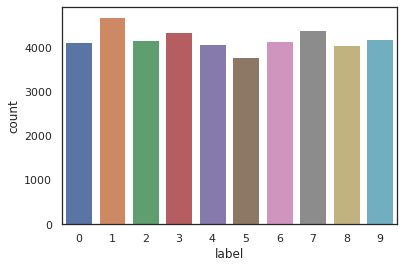

In [9]:
y_train = train["label"]

# Drop 'label' column
x_train = train.drop( labels=["label"], axis=1 )

# Free some space
del train

g = sns.countplot(y_train)

y_train.value_counts()

In [10]:
x_train.shape

(42000, 784)

In [11]:
y_train.shape

(42000,)

### Check for null or missing values

In [12]:
# Check data
x_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [13]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

No missing value in train and test datasets

### Normalisation
We perform a grayscale normalisation to reduce the effect of illumination differences.

Moreover the CNN faster on [0...1] data than on [0...255]

In [14]:
# Normalise the data
x_train = x_train / 255
test = test / 255

### Reshape

In [15]:
# Reshape image in 3 dimensions (height = 28px, widht=28px, canal =1)
x_train = x_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

Train and test images (28px x 28px) has been stocked into pandas.DataFrame as 1D vectors of 784 values.

We reshape all datga to 28x28x1 3D matrices.

Keras requries an extra dimension in the end which correspond to channels.

MNIST images are gray scaled so it use only 1 channel.

FOr RGB images, there are 3 channels, we sould have reshaped 784px vectors to 28x28x3 3D matrices.

### Label Encoding

In [16]:
# Encode labels to one hot vectors (eg, 2 -> [0,0,1,0,0,0,0,0,0])
y_train = to_categorical( y_train, num_classes=10 )

### Split training and validation set

In [17]:
# Set random seed
random_seed = 2

In [18]:
# Split train and validation set for fitting
x_train, x_val, y_train, y_val = train_test_split( x_train, y_train, test_size=0.1, random_state=random_seed )

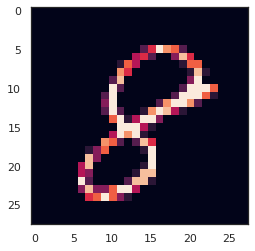

In [19]:
# Some examples
g = plt.imshow( x_train[0][:,:,0] )

## 2. CNN

I used the Keras Sequential API, where you have to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the first 2 conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

### Define CNN model

In [20]:
# Set the CNN model
# CNN architecture is in -> [ [Conv2D->relu]*2 -> MaxPool2D -> Dropout ] *2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(
    Conv2D(
        filters = 32,
        kernel_size = (5,5),
        padding = 'Same',
        activation = 'relu',
        input_shape = (28,28,1)
    )
)
model.add(
    Conv2D(
        filters = 32,
        kernel_size = (5,5),
        padding = 'Same',
        activation = 'relu'
    )
)
model.add(
    MaxPool2D( pool_size=(2,2) )
)
model.add(Dropout(0.25))


model.add(
    Conv2D(
        filters = 64,
        kernel_size = (3,3),
        padding = 'Same',
        activation = 'relu',
    )
)
model.add(
    Conv2D(
        filters = 64,
        kernel_size = (3,3),
        padding = 'Same',
        activation = 'relu',
    )
)
model.add(
    MaxPool2D( 
        pool_size=(2,2), 
        strides=(2,2) )
)
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="softmax"))

### Set optimizer and annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

I choosed RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [21]:
# Define Optimizer
optimizer = RMSprop(
    lr=0.001,
    rho=0.9,
    epsilon=1e-08,
    decay=0.0
)

In [22]:
# Compile model
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [30]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

In [32]:
epochs = 3 #Turn epochs to 30 to get 0.9907 accuracy
batch_size = 86

### Data augmentation
In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important :

Without data augmentation i obtained an accuracy of 98.114%
With data augmentation i achieved 99.67% of accuracy

In [ ]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [33]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False
        )  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees
Randomly Zoom by 10% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

In [34]:
# Fit the model
history = model.fit_generator(
    datagen.flow(
        x_train,
        y_train,
        batch_size=batch_size
    ),
    epochs = epochs, 
    validation_data = (x_val, y_val),
    verbose = 2,
    steps_per_epoch=x_train.shape[0], # batch size
    callbacks=[learning_rate_reduction]
)


ValueError: ignored